In [103]:
# # Import modules and set options
from bokeh.layouts import grid
from bokeh.models import ColumnDataSource, CategoricalColorMapper, annotations
from bokeh.models.widgets import DataTable, TableColumn, HTMLTemplateFormatter
from bokeh.plotting import figure, output_notebook, show, output_file, save

colors = ["#6EC8BE","#BE2369","#FFC30F","#694691","#EB1E23","#7682A4","#373C50","#A7DDD8",]

In [2]:
import pandas as pd
import numpy as np
from atomsci.ddm.utils import struct_utils as su
import atomsci.ddm.utils.rdkit_easy as rdk
# import HTML
%config Completer.use_jedi=False

rdk.setup_notebook()

Loading BokehJS ...

In [72]:
# Read CSV
df1 = pd.read_csv("./MRP4_hits_info.csv")
df1['source']='UCSF'
df1=df1.rename(columns={'Pubchem_CID':'ChEMBL_PubChem_CID'})
df1.columns

Index(['Compound', 'Name', 'ChEMBL_PubChem_CID', 'smiles', 'source', 'Target',
       'nconc', 'npts', 'nrep', 'IC50_uM', 'pIC50', 'notes', 'flag'],
      dtype='object')

In [73]:
df2=pd.read_csv('MRP4_chembl.csv', sep=';')
df2=df2[['Molecule Name', 'Molecule ChEMBL ID',  'Smiles', 'Target Name','Standard Relation', 'Standard Value','pChEMBL Value', 'Data Validity Comment', 'Comment',]]
df2.columns=['Name', 'ChEMBL_PubChem_CID', 'smiles', 'Target', 'Standard_Relation', 'IC50_uM','pIC50', 'flag', 'notes']
df2['source']='ChEMBL'
df2['Target']='MRP4'
df2['IC50_uM']=df2.IC50_uM/1000
df2.Standard_Relation=df2.Standard_Relation.str.replace("'='","=").str.replace("'<'","<").str.replace("'>'",">")
df2['Compound']=df2.ChEMBL_PubChem_CID
df=pd.concat([df1,df2])

In [74]:
df['base_rdkit_smiles']=df.smiles.apply(su.base_smiles_from_smiles)
df=df[['Compound','Name', 'ChEMBL_PubChem_CID', 'smiles', 'source', 'Target', 'nconc', 'npts',
       'nrep', 'Standard_Relation','IC50_uM', 'pIC50', 'notes', 'flag', 'base_rdkit_smiles']]
df.loc[df.Standard_Relation.isna(), 'Standard_Relation']='='
df=df[~df.pIC50.isna()]

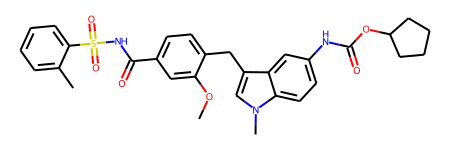

In [75]:
# add mol column
df=rdk.add_mol_column(df, 'base_rdkit_smiles', molecule_col='mol')

df.mol.iloc[0]

In [76]:
df[df.mol.isna()]

,Compound,Name,ChEMBL_PubChem_CID,smiles,source,Target,nconc,npts,nrep,Standard_Relation,IC50_uM,pIC50,notes,flag,base_rdkit_smiles,mol


In [89]:
import importlib
importlib.reload(rdk)

<module 'atomsci.ddm.utils.rdkit_easy' from '/home/apaulson/github_repos/AMPL/atomsci/ddm/utils/rdkit_easy.py'>

In [90]:
# # Calculate RDKit descriptors
df=rdk.calculate_descriptors(df)

2022-07-01 20:09:39,204 Note: calculate_descriptors() function now returns a new df and does not modify your df in place.
Use df=rdk.calculate_descriptors(df) to get the new data.


,Compound,Name,ChEMBL_PubChem_CID,smiles,source,Target,nconc,npts,nrep,Standard_Relation,IC50_uM,pIC50,notes,flag,base_rdkit_smiles,mol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,cluster
0,164,zafirlukast,5717,COc1cc(ccc1Cc1cn(C)c2ccc(NC(=O)OC3CCCC3)cc12)C(=O)NS(=O)(=O)c1ccccc1C,UCSF,MRP4,9.0,18.0,2.0,=,1.597553,5.796545,TCPL fit succeeded,"Only highest conc above baseline, active",COc1cc(C(=O)NS(=O)(=O)c2ccccc2C)ccc1Cc1cn(C)c2ccc(NC(=O)OC3CCCC3)cc12,,12.901306,-4.039915,12.901306,0.022131,0.278693,575.687,542.423,575.209007,214.0,0.0,0.411391,-0.496439,0.496439,0.411391,1.0,1.756098,2.487805,32.233274,10.010005,2.221445,-2.129513,2.301737,-2.306371,7.897503,0.098027,1.350689,1721.201688,29.147689,23.268689,24.085185,19.640199,13.496745,14.979908,10.337468,11.988292,7.43462,8.925833,5.328072,6.549593,-4.31,1.711400e+09,28.227046,11.660599,6.221701,239.065555,14.040826,11.853478,0.0,0.0,15.930471,6.09324,10.111326,17.934429,0.0,0.0,24.265468,85.695581,41.8191,12.005281,27.480597,38.614022,0.0,9.289195,7.047672,50.027295,12.426586,89.11432,0.0,5.749512,14.775746,10.481923,5.749512,0.0,38.19908,28.228648,6.923737,52.73163,71.755998,0.0,10.902925,0.0,115.73,22.023711,18.006871,0.0,16.562901,23.421171,47.713114,19.242532,37.255573,36.010716,10.038883,9.473726,40.904588,0.0,25.365602,3.80667,4.144406,-0.290895,17.066331,5.997774,1.671903,-0.583046,0.290323,41.0,2.0,9.0,1.0,0.0,1.0,3.0,1.0,4.0,7.0,2.0,10.0,8.0,1.0,0.0,1.0,5.0,5.69592,156.9097,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.
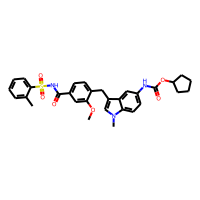
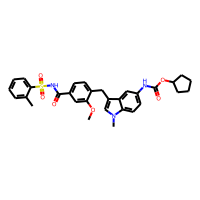

In [92]:
rdk.show_df(df.head(2))

In [93]:
%%time
# Cluster molecules by Morgan fingerprint
rdk.cluster_dataframe(df, molecule_column='mol', cluster_column='cluster', cutoff=0.4)

CPU times: user 40.1 ms, sys: 65 µs, total: 40.1 ms
Wall time: 38.7 ms


In [94]:
# align mols in clusters
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

for cluster in df.cluster.unique():
    if len(df[df.cluster==cluster])>1:
        tmp=df[df.cluster==cluster]
        ids=tmp.Name.tolist()
        # get list of mol objects from smiles
        mols=tmp.mol.tolist()
        template=mols[0]
        AllChem.Compute2DCoords(template)
        mcs = rdFMCS.FindMCS(mols, 
                      completeRingsOnly=True, 
                      ringMatchesRingOnly=True, 
                      timeout=10)
        patt = Chem.MolFromSmarts(mcs.smartsString)
        template_match = template.GetSubstructMatch(patt)
        newmols=[]
        for mol in mols:
            query_match = mol.GetSubstructMatch(patt)
            AllChem.Compute2DCoords(mol)
            rms = AllChem.AlignMol(mol, template, atomMap=list(zip(query_match,template_match)))
            
            newmols.append(mol)
        df.loc[df.cluster==cluster, 'mol']=mols

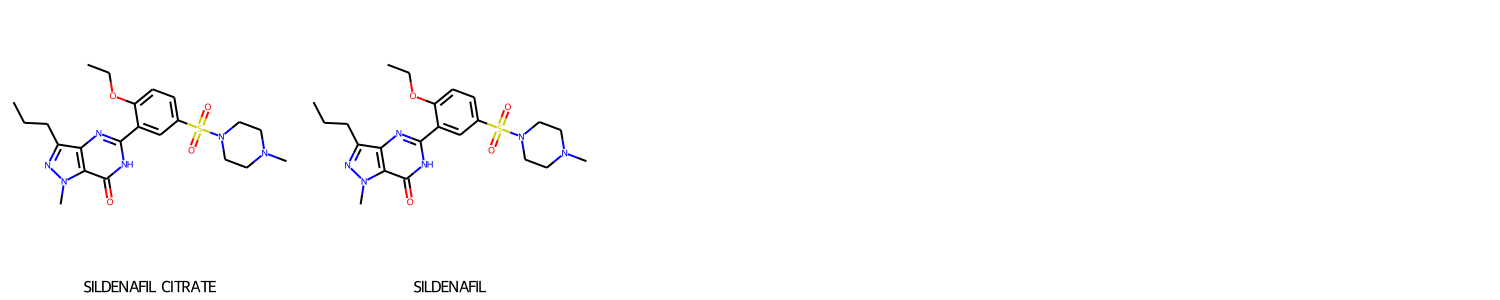

In [95]:
Draw.MolsToGridImage(mols, legends=[id for id in ids], molsPerRow=5, subImgSize=(300,300), useSVG=True)

In [111]:
# Add molecule HTML
# df=df.drop(columns='mol_html')
df['mol_html']=df.mol.apply(rdk.mol_to_html, type='svg', embed=True, width=200)

In [112]:
df=df.sort_values('cluster')

In [113]:
# Bokeh

output_file(filename="explore_mols.html", title="Explore MRP4 hit molecules")

x = 'cluster'
y = 'pIC50'
color = 'source'

tooltips = """
    <div>
        <div>
            @mol_html{safe}<br>
        </div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@Compound @Name</span><br>
            <span style="font-size: 15px;">Target: MRP4</span><br>
            <span style="font-size: 15px;">pIC50: @pIC50</span><br>
            <span style="font-size: 12px;">@flag</span><br>

        </div>
    </div>
"""


# Bokeh can't handle RDKit mol
mol_filter = (df.columns != 'mol') & (df.columns != 'Murcko')

# Shared source
source = ColumnDataSource(df.loc[:,mol_filter])   ### filtered for only some data even though clusters calc'd on all

fig = figure(title="Explore MRP4 hit molecules", tooltips=tooltips, y_range=(3.5,9), plot_width=1500, plot_height=500, tools='box_select,lasso_select,tap,pan,wheel_zoom,box_zoom,save,reset,help')

# Color by cluster
# colormap = linear_cmap(field_name=color, palette='Turbo256', low=min(df[color]), high=max(df[color]))
color_map = CategoricalColorMapper(factors=df[color].value_counts().index, palette=colors)

r = fig.scatter(x=x, y=y, source=source, size=10, color={'field':color, 'transform':color_map}, legend_group=color)
fig.xaxis.axis_label = x
fig.yaxis.axis_label = y

# For HTML in DataTable
html_template = HTMLTemplateFormatter(template='<%= value %>')

columns = [TableColumn(field="source", title='Source'),
           TableColumn(field="Compound", title='Compound'),
           TableColumn(field="Name", title='Name'),
           TableColumn(field="mol_html", formatter=html_template, title='Mol', ),
           TableColumn(field='cluster', title='cluster'),
           TableColumn(field='IC50_uM', title='IC50_uM'),
           TableColumn(field='pIC50', title='pIC50'),
           TableColumn(field='MolWt', title='MolWt', ),
           TableColumn(field='NumHDonors', title='NumHDon'),
           TableColumn(field='NumHAcceptors', title='NumHAcc'),
           TableColumn(field='MolLogP', title='MolLogP'),
           TableColumn(field='HeavyAtomCount', title='HeavAtmCt'),
           TableColumn(field='NumRotatableBonds', title='NumRotBonds'),
           TableColumn(field='TPSA', title='TPSA'),
           TableColumn(field='FractionCSP3', title='FracCSP3'),
          ]

table = DataTable(source=source, columns=columns, row_height=200, sizing_mode='stretch_width', selectable='checkbox', 
                  height=1000, 
                  autosize_mode='fit_columns')

# Show
g = grid([[fig],[table]])
save(g)
# show(g)

'/mnt/c/Users/akpau/box_drive/TCPL_Database/Step_6_tcpl_post/explore_mols.html'

In [106]:
df[['Compound', 'Name', 'ChEMBL_PubChem_CID', 'smiles', 'source', 'Target',
       'nconc', 'npts', 'nrep', 'Standard_Relation', 'IC50_uM', 'pIC50',
       'notes', 'flag','cluster']].to_csv('MRP4_hits.csv')

In [107]:
len(df)-60

129